<a href="https://colab.research.google.com/github/chanjaga/Power-Analysis-Attack/blob/main/%E7%B0%A1%E6%98%93%E7%89%88%E3%80%80%E7%9B%B8%E9%96%A2%E9%9B%BB%E5%8A%9B%E8%A7%A3%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ラウンド鍵1の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

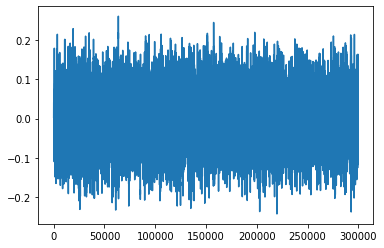

ラウンド鍵は11011001です(2進)
ラウンド鍵はd9です(16進)

[ラウンド鍵2の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

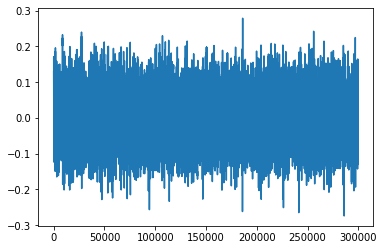

ラウンド鍵は00000111です(2進)
ラウンド鍵は7です(16進)

[ラウンド鍵3の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

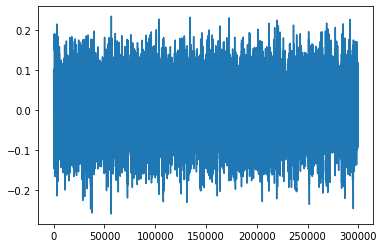

ラウンド鍵は11100110です(2進)
ラウンド鍵はe6です(16進)

[ラウンド鍵4の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

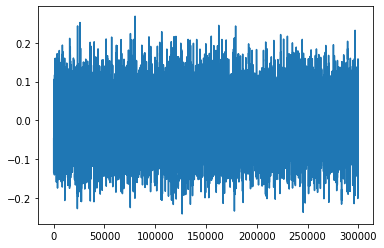

ラウンド鍵は01000101です(2進)
ラウンド鍵は45です(16進)

[ラウンド鍵5の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

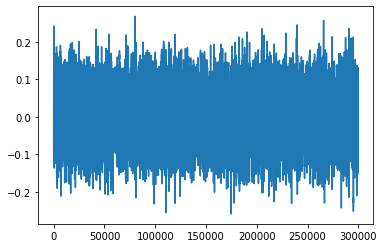

ラウンド鍵は11010101です(2進)
ラウンド鍵はd5です(16進)

[ラウンド鍵6の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

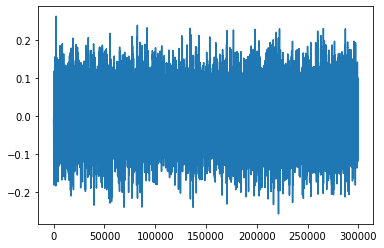

ラウンド鍵は10100010です(2進)
ラウンド鍵はa2です(16進)

[ラウンド鍵7の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

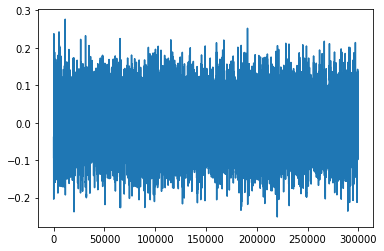

ラウンド鍵は01110000です(2進)
ラウンド鍵は70です(16進)

[ラウンド鍵8の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

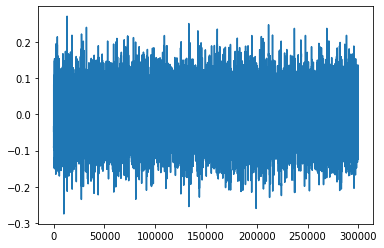

ラウンド鍵は10100110です(2進)
ラウンド鍵はa6です(16進)

[ラウンド鍵9の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

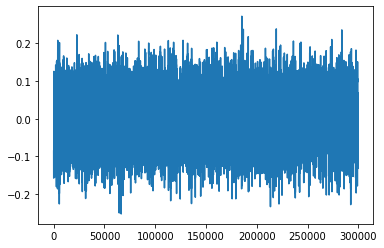

ラウンド鍵は11010000です(2進)
ラウンド鍵はd0です(16進)

[ラウンド鍵10の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

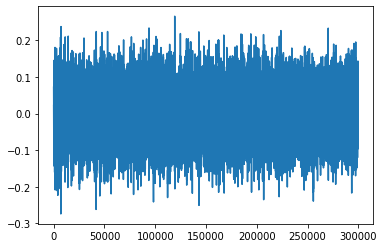

ラウンド鍵は10110010です(2進)
ラウンド鍵はb2です(16進)

[ラウンド鍵11の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

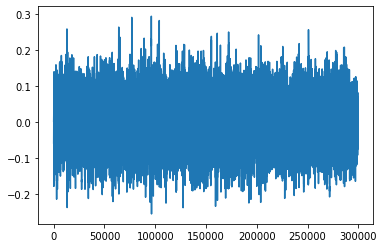

ラウンド鍵は10111000です(2進)
ラウンド鍵はb8です(16進)

[ラウンド鍵12の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

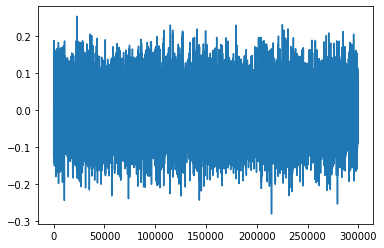

ラウンド鍵は01111011です(2進)
ラウンド鍵は7bです(16進)

[ラウンド鍵13の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

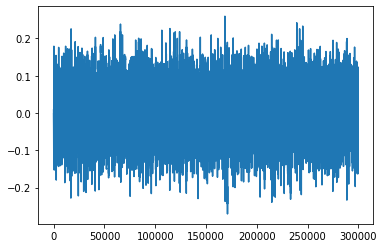

ラウンド鍵は11000001です(2進)
ラウンド鍵はc1です(16進)

[ラウンド鍵14の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

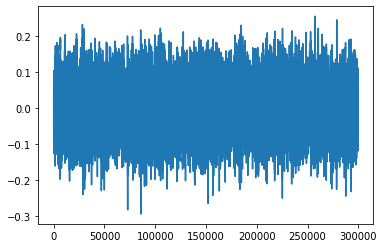

ラウンド鍵は01001101です(2進)
ラウンド鍵は4dです(16進)

[ラウンド鍵15の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

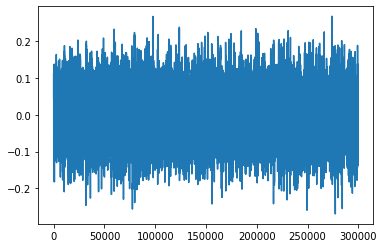

ラウンド鍵は11100110です(2進)
ラウンド鍵はe6です(16進)

[ラウンド鍵16の推定]


  0%|          | 0/299776 [00:00<?, ?it/s]

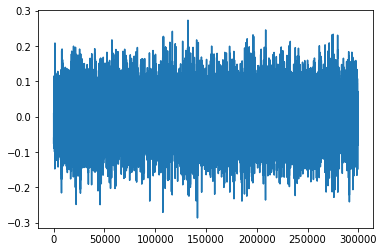

ラウンド鍵は10010010です(2進)
ラウンド鍵は92です(16進)

[***暗号鍵はd97e645d5a270a6d0b2b87bc14de692です***]


In [1]:
#簡易版　相関電力解析
import itertools
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance
     

#平文
plaintext = [list(i) for i in itertools.product([0, 1], repeat=8)]

#8bit予測鍵の生成
pre_round_key = [list(i) for i in itertools.product([0, 1], repeat=8)]

#トレース観測回数
obs_trace_times = 300000
     

#リーケージモデル
def leakage_model(pre_round_key,plaintext):
  leakage = [[0]*2**8]*2**8
  for i in range(2**8):
    for j in range(2**8):
      leakage[i][j] = distance.hamming(pre_round_key[i],plaintext[j]) + j*0.01 
  return leakage
     

#リーケージモデルに基づいた予測トレース（リーケージ）の生成
pre_trace = leakage_model(plaintext,pre_round_key)
     

#相関電力解析
def cpa(pre_trace,obs_trace):
  analysis_times = int(obs_trace_times/len(pre_trace[0])) * len(pre_trace[0])

  #解析
  correlation = [0]*analysis_times
  result_correlation = []
  for i in tqdm(range(analysis_times)):
      if len(obs_trace[i:i+256]) == 256:
        correlation[i] = np.corrcoef(pre_trace[0],obs_trace[i:i+256])
        #相関係数の取得
        result_correlation.append(correlation[i][1][0])

  #解析毎の相関係数のプロット
  plt.plot(result_correlation)
  plt.show()

  #相関係数を用いたラウンド鍵の特定
  round_key_index = result_correlation.index(max(result_correlation)) % 256
  round_key = pre_round_key[round_key_index]
  result_bin = "".join(map(str,round_key))
  hex_cal = 0
  for j in range(len(round_key)):
    hex_cal += round_key[j]*2**(len(round_key)-1-j)
  result_hex = format(hex_cal, 'x') #2進数→16進数

  print(f"ラウンド鍵は{result_bin}です(2進)")
  print(f"ラウンド鍵は{result_hex}です(16進)\n")
  return result_hex

#実行
round_key_list = []
for i in range(16):       #推定するラウンド鍵の個数を指定
  dumy_obs_trace = []         #ダミー観測トレース
  for _ in range(obs_trace_times):
    dumy_obs_trace.append(np.random.randint(0,3))
  print(f"[ラウンド鍵{i+1}の推定]")
  round_key_list.append(cpa(pre_trace,dumy_obs_trace))

print(f"[***暗号鍵は{''.join(round_key_list)}です***]")